## Neural Network with Tensorflow(Keras) 

Sequential Multi Layer Percepton (MLP) neural network built using Keras, containing: 


### Model Flow 

### Data Preprocessing
- collect and explore data
- normalize input features 
- split into 5 folds cross validation train/test datasets 
    
   
### Model Construction 
- Utilize Kera's sequential class to construct input, hidden, and output layers. Model consists of performaning matrix multiplications during each level and producing an activation output using mathematical functions. 
    
- Input layer: 
    - Takes feature inputs and intialize with random weights and biases 
    - Utilize activation function (ReLU, tanh, etc) to produce inputs for hidden layers
        
- Hidden Layers:
    - Decide on number of hidden layers and different parameters 
    - Takes our input data and performs mathematical operations to produce inputs to output layer

- Output Layer: 
    - Final step in neural network should produce a probability between 0-1 to classify 
        
   
### Model training 
- We can train (fit) our data using the constructed model. The network will iterativly(number of epochs) train and try to improve it's performance. Uses an optimizer in attempt to reduce the training loss, process know as gradiant descent, and achieve higher accuracy. 
    
- Loss Function:
    - Since this is a binary classification problem, use binary_crosscentropy to calculate the loss function between predicted and actual output
        
- Optimization: 
    - We optimize the neural network with an Adam optimizer.
    - Adam = Adaptive moment estimation, combination of RMSProp + Momentum
        
- Stochastic Gradiant Descent: 
    - Momentum takes past gradiants into account to smooth out the gradiant descent
    
    
### Model Evaluation 
- Confusing Matrix: Using Sklearn metrics library

    True Negative     False Positive 
    False Negative    True Positive 
    
- Accuracy = (TP + TN) / (TP + TN + FP + FN)
    - Accuracy needs to be considered depending on the problem
    
- Recall: TP / (TP + FN)
    - High recall indicates the class is correctly recognized
    - E.g. small number of false negatives
    
- Precision: TP / (TP + FP)
    - High precision indicates an example labled as positive 
        is indeed positive 
    
- F-Score: 2*recall*precision / (recall + precision)
    - F-score helps measure recall and precision at same time
    - It takes harmonic mean instead of arithmitic mean


### Area Under the Curve (AUC): Performance Measurement 

- calculating the AUC using the trapezoidal rule for the 
    ROC-curve
- ROC is a probability curve and AUC represents degree of separability
- Shows how much a model is capable of distinguishing between classes
    - Higher AUC, better at predicting 0 as 0, 1 as 1
    - E.g. better at disease diagnosis

- TPR (True pos rate) / Recall / Sensitivity = TP / (TP+FN)
- FPR (False pos rate) = 1 - Specificity
- Specificity = TN / (TN + FP)

- Sensitivity and Specificity are inversely proportional to each other

    
    

In [11]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import optimizers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Data preprocessing 
df = pd.read_csv("Data\MLPHypertension.csv")

indexedData = df[['SEX', 'WC', 'SBP', 'DBP', 'HTN']]
cols_to_norm = [ 'WC', 'SBP', 'DBP']
indexedData = indexedData.dropna()
indexedData.info()
data = indexedData

X = data[['SEX', 'WC', 'SBP', 'DBP']]
Y = data[['HTN']]
indexedData.head()
indexedData.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1159 entries, 0 to 1158
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEX     1159 non-null   int64  
 1   WC      1159 non-null   float64
 2   SBP     1159 non-null   float64
 3   DBP     1159 non-null   float64
 4   HTN     1159 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 54.3 KB


,SEX,WC,SBP,DBP,HTN
count,1159.000000,1159.000000,1159.000000,1159.000000,1159.000000
mean,1.710958,88.477308,123.100086,80.867558,0.389129
std,0.453513,14.083142,20.169155,12.414054,0.487763
min,1.000000,25.000000,76.000000,40.000000,0.000000
25%,1.000000,81.000000,110.000000,70.000000,0.000000
50%,2.000000,90.000000,120.000000,80.000000,0.000000
75%,2.000000,98.000000,138.500000,90.000000,1.000000
max,2.000000,130.000000,200.000000,125.000000,1.000000


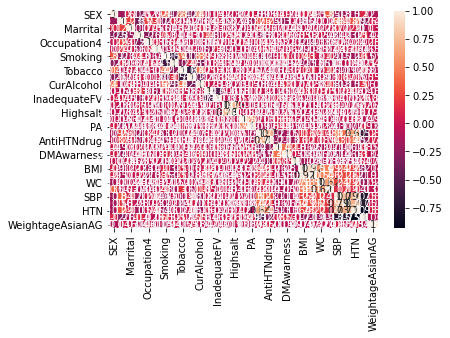

In [13]:
sns.heatmap(df.corr(), annot = True)

In [14]:
# standardizing input features 
seed = 7
np.random.seed(seed)
# sc = StandardScaler()
# X = sc.fit_transform(X)
X = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns, index = X.index)

kfold = StratifiedKFold(n_splits =5, shuffle = True, random_state = seed)
cvscores = []
X.head()

,SEX,WC,SBP,DBP
0,0.637615,0.108168,-0.153771,-0.069915
1,0.637615,-0.175982,-0.649791,-1.520511
2,0.637615,0.676469,1.830312,1.541857
3,0.637615,0.747506,0.243046,-1.278745
4,0.637615,-1.028432,-1.145812,-1.681688


In [15]:
""" 
Constructing the layers of our neural network
Kernel is the weight matrix, kernel initialization sets up 
     the initial random weights of the keras layers 
   
The output layer uses a sigmoid activation since it's a 
    binary classification 
    
K-Folds Cross Validation:
    Method of testing robustness of model by running the model K times and using the average
"""
for train, test in kfold.split(X, Y):
    
    train_X, valid_X = X.iloc[train], X.iloc[test]
    train_Y, valid_Y = Y.iloc[train], Y.iloc[test]
    
    classifier = Sequential()
    #Input layer
    classifier.add(Dense(4,kernel_initializer ='random_uniform', 
                         kernel_regularizer=keras.regularizers.l2(l=0.01), 
                         input_dim = 4))
    classifier.add(BatchNormalization())
    classifier.add(Activation(activation='relu'))
    
    #First hidden layer
    classifier.add(Dense(8,kernel_initializer='random_uniform',
                         kernel_regularizer=keras.regularizers.l2(l=0.01)))
    classifier.add(BatchNormalization())
    classifier.add(Activation(activation='relu'))
    
    #Output layer
    classifier.add(Dense(1, kernel_initializer='random_uniform', 
                         kernel_regularizer=keras.regularizers.l2(l=0.01)))
    classifier.add(BatchNormalization())
    classifier.add(Activation(activation='sigmoid'))
    
    #Model training and optimization 
    adam = optimizers.adam(lr = .001)
    classifier.compile(loss='binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])   
    classifier.fit(train_X, train_Y, batch_size=32, epochs= 15)

    import pickle
    filename = 'Data\Hypertension MLP.sav'
    pickle.dump(classifier, open(filename, 'wb'))

    eval_model = classifier.evaluate(valid_X, valid_Y)
    print("%s: %.2f%%" % (classifier.metrics_names[1], eval_model[1]*100))
    cvscores.append(eval_model[1] * 100)
                                 
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))                                

Epoch 1/15
927/927 [==============================] - 1s 1ms/step - loss: 0.5156 - accuracy: 0.8069
Epoch 2/15
927/927 [==============================] - 0s 93us/step - loss: 0.4169 - accuracy: 0.9245
Epoch 3/15
927/927 [==============================] - 0s 83us/step - loss: 0.3911 - accuracy: 0.9277
Epoch 4/15
927/927 [==============================] - 0s 96us/step - loss: 0.3696 - accuracy: 0.9299

In [16]:
y_predict = classifier.predict(valid_X)
y_predict = (y_predict > 0.5)

In [17]:
"""
Producing confusing matrix and report 

Confusing Matrix: 
    True Negative     False Positive 
    False Negative    True Positive 
    
Accuracy = (TP + TN) / (TP + TN + FP + FN)
    - Accuracy needs to be considered depending on the problem
Recall: TP / (TP + FN)
    - High recall indicates the class is correctly recognized
    - E.g. small number of false negatives
Precision: TP / (TP + FP)
    - High precision indicates an example labled as positive 
        is indeed positive 
F-Score: 2*recall*precision / (recall + precision)
    - F-score helps measure recall and precision at same time
    - It takes harmonic mean instead of arithmitic mean

"""
print(metrics.accuracy_score(valid_Y, y_predict))
print(confusion_matrix(valid_Y, y_predict))
print(classification_report(valid_Y, y_predict))

0.9523809523809523
[[138   3]
 [  8  82]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       141
           1       0.96      0.91      0.94        90

    accuracy                           0.95       231
   macro avg       0.95      0.94      0.95       231
weighted avg       0.95      0.95      0.95       231



[[138   3]
 [  8  82]]


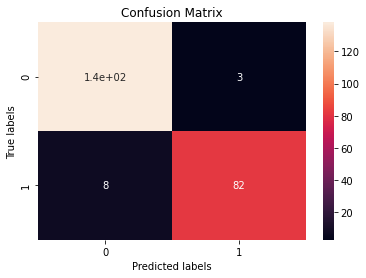

In [18]:
labels = ['HTN']
cm = confusion_matrix(valid_Y, y_predict)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');


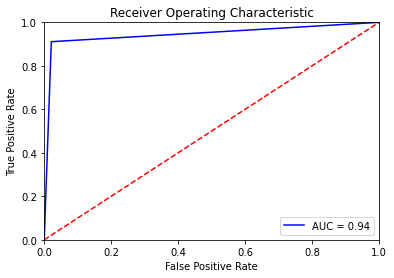

In [19]:
"""
    Area Under the Curve (AUC): Performance Measurement 
- calculating the AUC using the trapezoidal rule for the 
    ROC-curve
- ROC is a probability curve and AUC represents degree of separability
- Shows how much a model is capable of distinguishing between classes
    - Higher AUC, better at predicting 0 as 0, 1 as 1
    - E.g. better at disease diagnosis

TPR (True pos rate) / Recall / Sensitivity = TP / (TP+FN)
FPR (False pos rate) = 1 - Specificity
Specificity = TN / (TN + FP)

Sensitivity and Specificity are inversely proportional to each other

"""

# calculate the fpr and tpr for all thresholds of the classification
# preds = y_pred[:,1]
fpr, tpr, threshold = metrics.roc_curve(valid_Y, y_predict)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()